In [26]:
import torch
import torchvision as tv
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as fxnl
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

In [27]:
gpu_device = torch.device("cuda:0")

# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])


In [28]:
# Datasets
train_set = tv.datasets.FashionMNIST('./dataset', download=True, train=True, transform=transform)
test_set = tv.datasets.FashionMNIST('./dataset', download=True, train=False, transform=transform)

In [29]:
# Data Loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)

# Classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [30]:
# Helper fxn to show image
def display_image(image, one_channel=False):
    if one_channel:
        image = image.mean(dim=0)
    image = image / 2 +0.5
    np_image = image.numpy()
    if one_channel:
        plt.imshow(np_image, cmap="Greys")
    else:
        plt.imshow(np.transpose(np_image, (1, 2, 0)))

In [31]:
# Classifier Model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.conv_layer_one = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pooling_layer_one = nn.MaxPool2d(2, 2)
        self.conv_leyer_two = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.flatten_layer_one = nn.Linear(16 * 4 * 4, 120)
        self.flatten_layer_two = nn.Linear(120, 84)
        self.flatten_layer_three = nn.Linear(84, 10)
    
    def forward(self, input_tensor: torch.Tensor):
        input_tensor = self.pooling_layer_one(fxnl.relu(self.conv_layer_one(input_tensor)))
        input_tensor = self.pooling_layer_one(fxnl.relu(self.conv_leyer_two(input_tensor)))
        input_tensor = input_tensor.view(-1, 16 * 4 * 4)
        input_tensor = fxnl.relu(self.flatten_layer_one(input_tensor))
        input_tensor = fxnl.relu(self.flatten_layer_two(input_tensor))
        input_tensor = self.flatten_layer_three(input_tensor)

        return input_tensor

In [32]:
neural_net = NeuralNet()#.to(gpu_device)
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.SGD(neural_net.parameters(), lr=0.001, momentum=0.9)

In [33]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

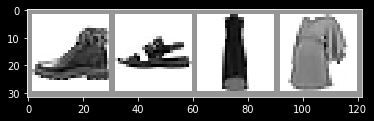

In [34]:
# Writing to TensorBoard
data_iterator = iter(train_loader)
images, labels = data_iterator.next()

image_grid = tv.utils.make_grid(images)

display_image(image=image_grid, one_channel=True)



In [35]:
#Write to tensorboard
writer.add_image("four_fashion_mnist_images", image_grid)

In [36]:
# Inspect the Model using tensorboard
writer.add_graph(neural_net, images)
writer.close()

In [37]:
# Adding a Projector to TensorBoard
def select_n_random(data, labels, num=10):
    assert len(data) == len(labels)

    permutation = torch.randperm(len(data))
    return data[permutation][:num], labels[permutation][:num]


In [38]:
images, labels = select_n_random(train_set.data, train_set.targets)

class_labels = [classes[label] for label in labels]

features = images.view(-1, 28 * 28)

writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

AttributeError: module 'tensorflow._api.v1.io.gfile' has no attribute 'get_filesystem'

In [39]:
# Tracking model training with TensorBoard
def images_to_probs(net, images):
    output = net(images)
    _, prediction_tensor = torch.max(output, 1)
    predictions = np.squeeze(prediction_tensor.cpu().numpy())
    return predictions, [fxnl.softmax(ele, dim=0)[idx].item() for idx, ele in zip(predictions, output)]

def plot_classes_preds(net, images, labels):
    predictions, probabilities = images_to_probs(net, images)
    figure = plt.figure(figsize=(12, 48))

    for idx in np.arange(4):
        ax = figure.add_subplot(1, 4, idx + 1, xticks=[], yticks=[])
        display_image(images[idx].cpu(), one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(classes[predictions[idx]], probabilities[idx] * 100.0, classes[labels[idx]]), color=("green" if predictions[idx] == labels[idx].item() else "red"))
    return figure

In [40]:
# Sample Train Model
running_loss= 0.0
neural_net = NeuralNet().to(gpu_device)
for epoch in range(1):
    for idx, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(gpu_device), data[1].to(gpu_device)
        optimizer_function.zero_grad()
        outputs = neural_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer_function.step()

        running_loss += loss.item()
        if idx % 1000 == 999:
            # Tesnorboard write loss
            writer.add_scalar("training_loss", running_loss / 1000, epoch * len(train_loader) + idx)

            writer.add_figure("predictions vs. actuals", plot_classes_preds(neural_net, inputs, labels), global_step=epoch * len(train_loader) + idx)

            running_loss = 0.0
print()
print("Finished training")


Finished training


In [ ]:
# Accessing trained models with TensorBoard

class_probs = []
class_preds = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(gpu_device), data[1].to(gpu_device)
        output = neural_net(images)
        class_probs_batch = [fxnl.softmax(ele, dim=0) for ele in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index], tensorboard_preds, tensorboard_probs, global_step=global_step)
    writer.close()



In [ ]:
for idx in range(len(classes)):
    add_pr_curve_tensorboard(idx, test_probs, test_preds)